In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 한글 폰트 설정 (환경에 따라 필요시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
# plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

                 종가  12m_log_return   z_score
날짜                                           
2025-10-01  4107.50        0.474312  1.990310
2025-11-01  3926.59        0.469274  1.965640
2025-12-01  4214.17        0.563196  2.425523
2026-01-01  5224.36        0.730118  3.242838
2026-02-01  5354.49        0.748618  3.333423


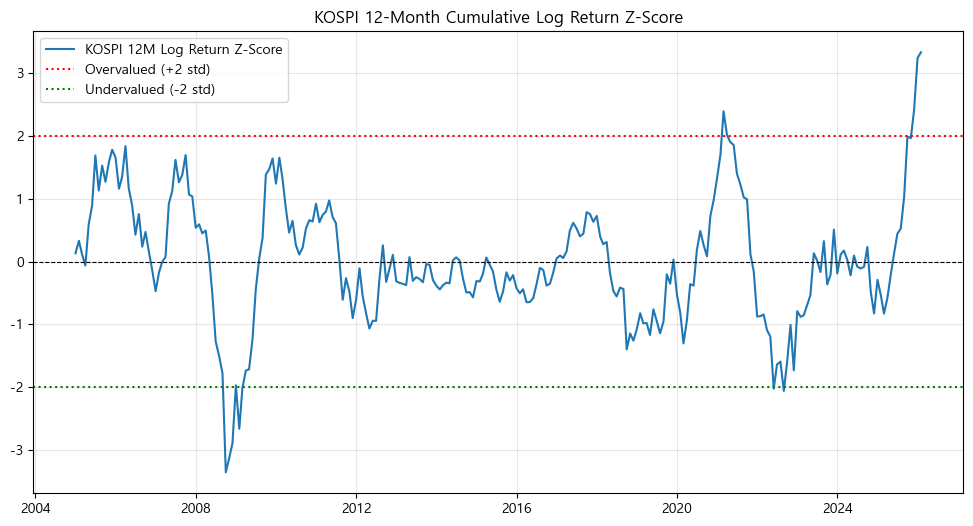

'data/data_z_score/new_kospi_z_score.csv' 파일이 저장되었습니다.


In [3]:
# 코스피 데이터 불러오기
df_kospi = pd.read_csv('data/코스피지수(1981.5월부터).csv')
# 불러온 데이터 범위 정하기 (2004년 1월 1일부터 2026년 2월 1일까지)
df_kospi['날짜'] = pd.to_datetime(df_kospi['날짜'])
df_kospi = df_kospi[(df_kospi['날짜'] >= '2004-01-01') & (df_kospi['날짜'] <= '2026-02-01')]
# 날짜 정렬 (과거 -> 현재)
df_kospi = df_kospi.sort_values(by='날짜')

# 날짜를 인덱스로 설정
df_kospi.set_index('날짜', inplace=True)
# 종가 컬럼의 쉼표 제거 및 숫자 변환
df_kospi['종가'] = df_kospi['종가'].astype(str).str.replace(',', '').astype(float)
# 결측지 확인 및 제거
df_kospi['종가'] = df_kospi['종가'].ffill()
# 12개월 누적 로그 수익률 계산
# 공식: ln(현재 종가) - ln(12개월 전 종가)
df_kospi['log_price'] = np.log(df_kospi['종가'])
df_kospi['12m_log_return'] = df_kospi['log_price'].diff(12)
# Z-Score 계산
# 전체 기간의 평균과 표준편차 사용
mean_return = df_kospi['12m_log_return'].mean()
std_return = df_kospi['12m_log_return'].std()

df_kospi['z_score'] = (df_kospi['12m_log_return'] - mean_return) / std_return
# 결과 확인
print(df_kospi[['종가', '12m_log_return', 'z_score']].tail())
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_kospi.index, df_kospi['z_score'], label='KOSPI 12M Log Return Z-Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(2, color='red', linestyle=':', label='Overvalued (+2 std)')
plt.axhline(-2, color='green', linestyle=':', label='Undervalued (-2 std)')
plt.title('KOSPI 12-Month Cumulative Log Return Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# CSV 파일 저장
output_filename = 'data/data_z_score/new_kospi_z_score.csv'
df_kospi.to_csv(output_filename, encoding='utf-8-sig') # 한글 깨짐 방지를 위해 utf-8-sig 사용
print(f"'{output_filename}' 파일이 저장되었습니다.")

            Credit_Spread  12M_Change   Z_score
날짜                                             
2025-09-01          0.462      -0.118  0.173283
2025-10-01          0.427      -0.148  0.219349
2025-11-01          0.419      -0.151  0.223955
2025-12-01          0.492      -0.154  0.228562
2026-01-01          0.501      -0.157  0.233169


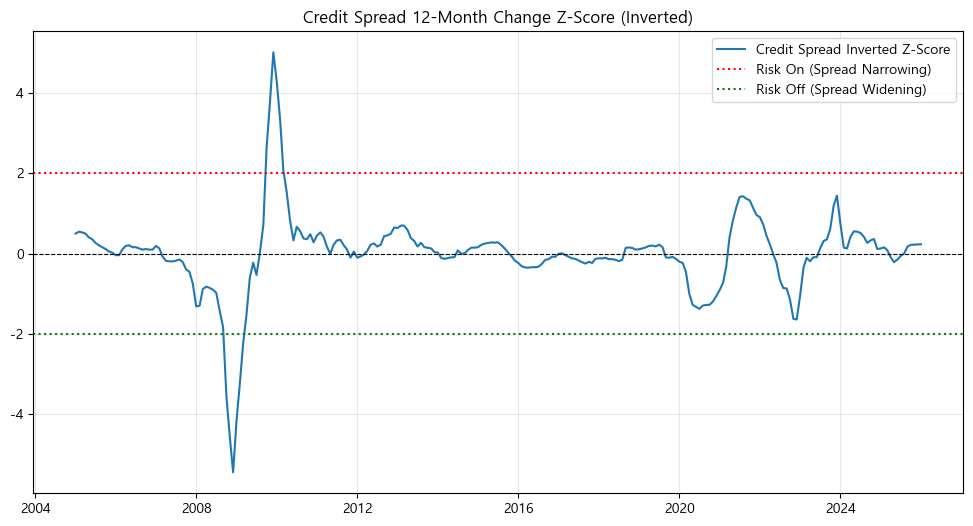

'data/data_z_score/Credit_Spread_Z_Score.csv' 파일이 저장되었습니다.


In [4]:
# 시장금리 데이터 불러오기
df_new_spread = pd.read_csv('data/시장금리(1995.5월부터).csv')
# 데이터 전처리 (행/열 변환)
# '계정항목'이 '국고채(3년)'과 '회사채(3년, AA-)'인 행을 찾음
treasury_row = df_new_spread[df_new_spread['계정항목'] == '국고채(3년)']
company_row = df_new_spread[df_new_spread['계정항목'] == '회사채(3년, AA-)']
# 날짜 컬럼들만 추출
date_cols = df_new_spread.columns[4:]
# 새로운 DataFrame 생성
df = pd.DataFrame({
    'Treasury': treasury_row.iloc[0][date_cols].values,
    'Company': company_row.iloc[0][date_cols].values
}, index=date_cols)
# 인덱스를 날짜 형식으로 변환 및 정렬
df.index.name = '날짜'
df.index = pd.to_datetime(df.index, format='%Y/%m')
df = df.sort_index()
# 날짜 범위 설정 (2004년 1월 1일부터 2026년 2월 1일까지)
df = df[(df.index >= '2004-01-01') & (df.index <= '2026-02-01')]
df = df.astype(float)
# 데이터 타입 변환 (문자열 -> 숫자)
df['Treasury'] = pd.to_numeric(df['Treasury'])
df['Company'] = pd.to_numeric(df['Company'])
# 신용스프레드 계산
# 공식: 회사채금리 - 국고채금리
df['Credit_Spread'] = df['Company'] - df['Treasury']
# 12개월 변화량 계산
# 금리는 로그 수익률보다 단순 등락폭(bp)을 주로 사용합니다.
df['12M_Change'] = df['Credit_Spread'].diff(12)
# Z-Score 계산
mean_val = df['12M_Change'].mean()
std_val = df['12M_Change'].std()
# 부호 반전 적용
df['Z_score'] = -1 * ((df['12M_Change'] - mean_val) / std_val)
# 결과 확인
print(df[['Credit_Spread', '12M_Change', 'Z_score']].tail())
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Z_score'], label='Credit Spread Inverted Z-Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(2, color='red', linestyle=':', label='Risk On (Spread Narrowing)')
plt.axhline(-2, color='green', linestyle=':', label='Risk Off (Spread Widening)')
plt.title('Credit Spread 12-Month Change Z-Score (Inverted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# CSV 파일 저장
output_filename = 'data/data_z_score/Credit_Spread_Z_Score.csv'
df.to_csv(output_filename, encoding='utf-8-sig')
print(f"'{output_filename}' 파일이 저장되었습니다.")

                 종가  12m_log_return   z_score
날짜                                           
2025-10-01  1429.22        0.040437 -0.301308
2025-11-01  1467.62        0.050984 -0.407616
2025-12-01  1440.62       -0.024790  0.356117
2026-01-01  1450.80       -0.004463  0.151240
2026-02-01  1451.28       -0.007223  0.179050


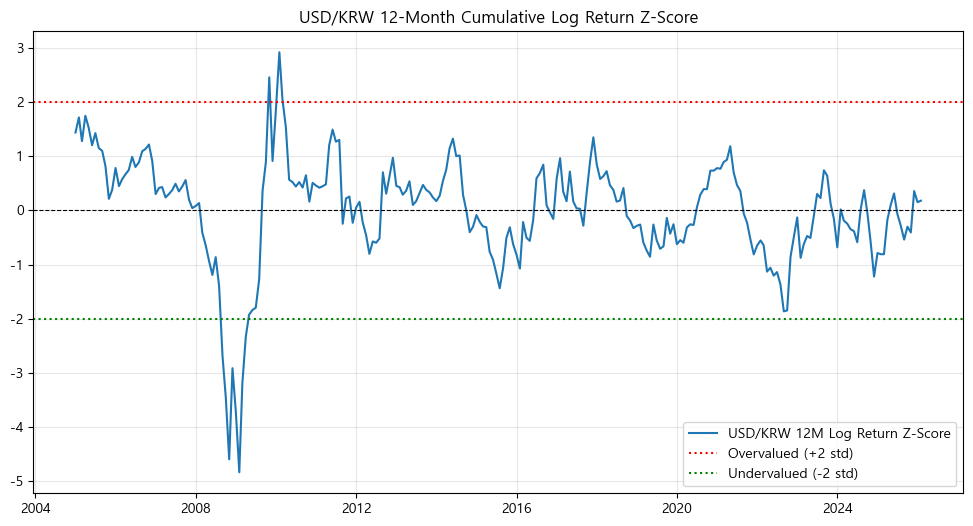

'data/data_z_score/USD_KRW_z_score.csv' 파일이 저장되었습니다.


In [5]:
# 환율 데이터 불러오기
df_usd_krw = pd.read_csv('data/USD_KRW(1981.5월부터).csv')
# 불러온 데이터 범위 정하기 (2004년 1월 1일부터 2026년 2월 1일까지)
df_usd_krw['날짜'] = pd.to_datetime(df_usd_krw['날짜'])
df_usd_krw = df_usd_krw[(df_usd_krw['날짜'] >= '2004-01-01') & (df_usd_krw['날짜'] <= '2026-02-01')]
# 날짜 정렬 (과거 -> 현재)
df_usd_krw = df_usd_krw.sort_values(by='날짜')

# 날짜를 인덱스로 설정
df_usd_krw.set_index('날짜', inplace=True)
# 종가만 사용
# 종가 컬럼의 쉼표 제거 및 숫자 변환
df_usd_krw['종가'] = df_usd_krw['종가'].str.replace(',', '').astype(float)
# 결측치 처리
# 결측지 확인 및 제거
df_usd_krw['종가'] = df_usd_krw['종가'].ffill()
# 12개월 누적 로그 변화율 계산
# 공식: ln(현재 종가) - ln(12개월 전 종가)
df_usd_krw['log_price'] = np.log(df_usd_krw['종가'])
df_usd_krw['12m_log_return'] = df_usd_krw['log_price'].diff(12)  # 12개월(1년) 차분
# Z-Score 계산 (부호 반전 적용)
# 전체 기간의 평균과 표준편차 사용
mean_return = df_usd_krw['12m_log_return'].mean()
std_return = df_usd_krw['12m_log_return'].std()
# Z-score 계산 후 -1을 곱함
df_usd_krw['z_score'] = -1 * ((df_usd_krw['12m_log_return'] - mean_return) / std_return)
# 결과 확인
print(df_usd_krw[['종가', '12m_log_return', 'z_score']].tail())
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_usd_krw.index, df_usd_krw['z_score'], label='USD/KRW 12M Log Return Z-Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(2, color='red', linestyle=':', label='Overvalued (+2 std)')
plt.axhline(-2, color='green', linestyle=':', label='Undervalued (-2 std)')
plt.title('USD/KRW 12-Month Cumulative Log Return Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# CSV 파일 저장
output_filename = 'data/data_z_score/USD_KRW_z_score.csv'
df_usd_krw.to_csv(output_filename, encoding='utf-8-sig') # 한글 깨짐 방지를 위해 utf-8-sig 사용
print(f"'{output_filename}' 파일이 저장되었습니다.")

In [6]:
# 금융 지표 계산을 위한 스프레드, 코스피, 환율리 z-score 계산 데이터 불러오기
df_spread = pd.read_csv('data/data_z_score/Credit_Spread_Z_Score.csv', index_col='날짜', parse_dates=True)
df_kospi = pd.read_csv('data/data_z_score/new_kospi_z_score.csv', index_col='날짜', parse_dates=True)
df_exchange = pd.read_csv('data/data_z_score/USD_KRW_z_score.csv', index_col='날짜', parse_dates=True)

In [7]:
# 데이터 통합
combined_fin = df_spread[['Z_score']].rename(columns={'Z_score': 'credit_spread'}).join(
    df_kospi[['z_score']].rename(columns={'z_score': 'kospi'}), how='inner').join(
    df_exchange[['z_score']].rename(columns={'z_score': 'exchange'}), how='inner')

In [8]:
# 금융 지수 계산
combined_fin['fin_index'] = combined_fin.mean(axis=1)

In [9]:
# 형식 맞추기 및 저장
final_fin_output = combined_fin.reset_index().rename(columns={'index': 'date'})
final_fin_output = final_fin_output.dropna() # 초기 12개월분 제외

final_fin_output.to_csv('data/금융지표계산.csv', index=True, encoding='utf-8-sig')
print("금융 종합지표 파일이 'data/금융지표계산.csv'로 저장되었습니다.")

금융 종합지표 파일이 'data/금융지표계산.csv'로 저장되었습니다.


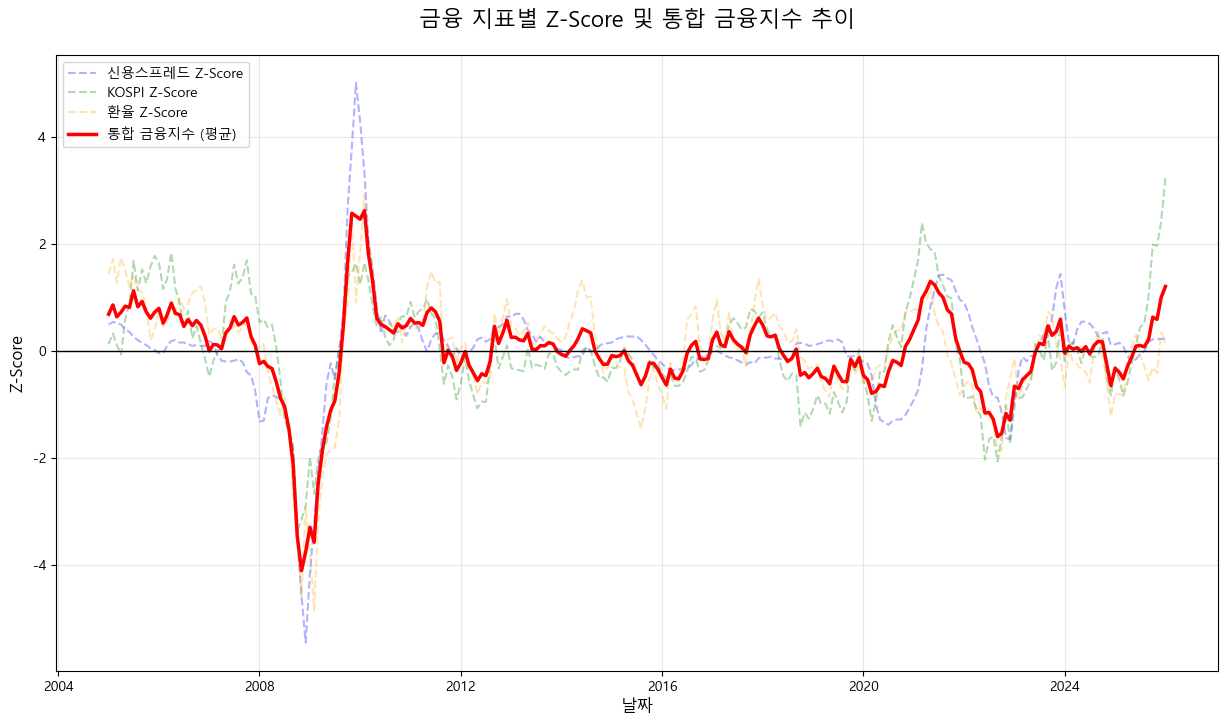

In [10]:
# 시각화
# 한글 폰트 설정 (환경에 따라 필요시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
# plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 8))

# 개별 지표들 (Credit Spread, KOSPI, Exchange) 흐릿하게 출력
plt.plot(combined_fin.index, combined_fin['credit_spread'], label='신용스프레드 Z-Score', color='blue', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['kospi'], label='KOSPI Z-Score', color='green', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['exchange'], label='환율 Z-Score', color='orange', alpha=0.3, linestyle='--')

# 통합 금융 지수 (fin_index)
plt.plot(combined_fin.index, combined_fin['fin_index'], label='통합 금융지수 (평균)', color='red', linewidth=2.5)

# 기준선 (Z-score = 0) 추가
plt.axhline(0, color='black', linewidth=1, linestyle='-')

# 차트 꾸미기
plt.title('금융 지표별 Z-Score 및 통합 금융지수 추이', fontsize=16, pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()